In [280]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from IPython.display import clear_output

$y = 2X + 1 + \epsilon (X-5) \in \mathbb{R}^N$

$X_i \sim \mathcal{U}(0, 10)$ for all $i \in [N]$

$ \epsilon \sim \mathcal{N}(0,I_{N \times N})$

$N  = 1000$

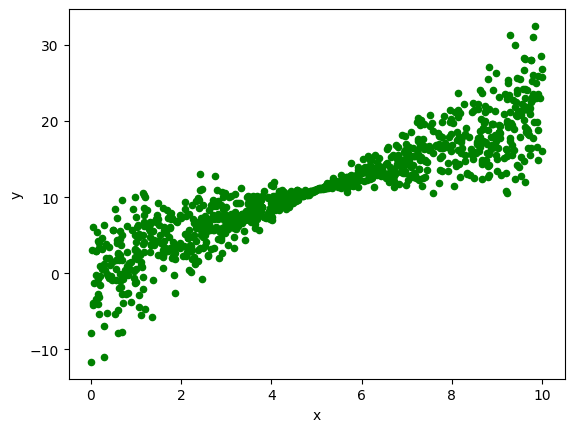

In [246]:
np.random.seed(0)
n = 1000
X = np.random.uniform(0, 10, size=(n, 1)).astype(np.float32)
y = (2 * X + 1 + np.random.normal(0, 1, size=(n, 1)) * (X - 5)).astype(
    np.float32
)  # Heteroscedasticity

data = pd.DataFrame({"x": X.squeeze(), "y": y.squeeze()}).plot(kind="scatter", x="x", y="y", color="green");

In [247]:
class Network(nn.Module):
    def __init__(self, num_input_features):
        super().__init__()
        self.layer1 = nn.Linear(num_input_features, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 1)


    def forward(self, x):
        x1 = F.relu(self.layer1(x))
        x2 = F.relu(self.layer2(x1))
        x3 = self.layer3(x2)
        return x3

In [248]:
X_torch = torch.from_numpy(X)
y_torch = torch.from_numpy(y)

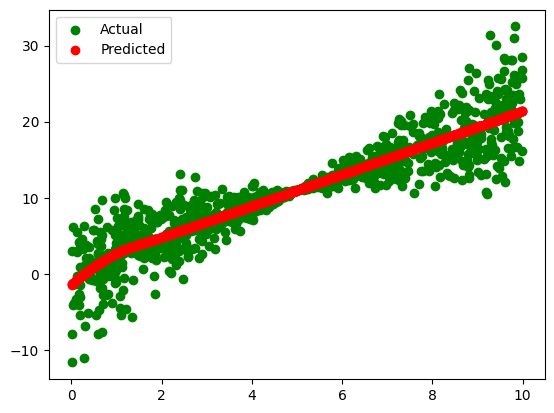

epoch=92/100 | loss=7.631711959838867
epoch=93/100 | loss=7.6313395500183105
epoch=94/100 | loss=7.6314802169799805
epoch=95/100 | loss=7.6318817138671875
epoch=96/100 | loss=7.632280349731445
epoch=97/100 | loss=7.632469654083252
epoch=98/100 | loss=7.632322788238525
epoch=99/100 | loss=7.631827354431152
epoch=100/100 | loss=7.631057262420654


In [249]:
model = Network(1)
model.train()

loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters())

fig, ax = plt.subplots()
epochs = 100
scatter_actual = ax.scatter(X_torch, y_torch, color="green", label="Actual")
y_hat = model(X_torch)
scatter_predicted = ax.scatter(
    X_torch, y_hat.detach().numpy().squeeze(), color="red", label="Predicted"
)
plt.legend()
plt.show()

for epoch in range(epochs):
    optimizer.zero_grad()
    y_hat = model(X_torch)
    loss = loss_fn(y_hat, y_torch)
    print(f"epoch={epoch+1}/{epochs} | loss={loss.item()}")
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        # Update the predicted points in the existing plot
        scatter_predicted.remove()
        scatter_predicted = ax.scatter(
            X_torch, y_hat.detach().numpy().squeeze(), color="red", label="Predicted"
        )
        clear_output(wait=True)
        display(fig)


# Bayes by backprop

In [250]:
import torch
from torch.distributions import Normal, Independent, Categorical, MixtureSameFamily



def create_gmm(dim, sigmas, weights):
    """
    Creates a Gaussian Mixture Model (GMM) of multivariate normal of size dim with mean 0 and standard deviations provided by sigmas.

    Args:
        dim (int): The number of parameters.
        sigmas (list of float): Standard deviations for the Gaussian components.
        weights (list of float): Mixture weights for each component, should sum to 1.

    Returns:
        MixtureSameFamily: A Gaussian Mixture Model distribution with multivariate normal components.
        sum(i=1...len(sigmas)) weight[i] * N(0, sigma[i])

    Example:
        >>> w = torch.cat([param.flatten() for param in model.parameters()])
        >>> p_w = create_gmm(w.shape[0], (1.0, 0.1), (0.75, 0.25))
        >>> p_w.log_prob(w)
        tensor(1402409.1250, grad_fn=<LogsumexpBackward0>)
    """

    # Create zero mean vectors for each component
    means = torch.zeros((len(sigmas), dim))  # Shape: (num_components, dim)

    # Create diagonal standard deviations for each component based on sigmas
    stds = torch.stack(
        [torch.ones(dim) * sigma for sigma in sigmas]
    )  # Shape: (num_components, dim)

    # Use Normal + Independence instead of MultivariateNormal to prevent too many non-sparse covariance matrices
    # Define the normal distributions with zero means and specified standard deviations
    normal_dists = Normal(means, stds)  # Shape: (num_components, dim)

    # Wrap each normal in an Independent distribution to treat each dimension as independent
    independent_dists = Independent(
        normal_dists, 1
    )  # Makes each Normal distribution multivariate with diagonal covariance

    # Define the categorical distribution over components with specified weights
    cat = Categorical(torch.tensor(weights))

    # Create the Gaussian Mixture Model
    gmm = MixtureSameFamily(cat, independent_dists)

    return gmm


In [251]:
class BayesNetwork(nn.Module):
    def __init__(self, num_input_features):
        super().__init__()
        self.num_input_features = num_input_features
        self.dtype = torch.float32
        self.num_weights = num_input_features * 128 + 128 * 128 + 128
        self.mu = nn.Parameter(torch.zeros(self.num_weights, dtype=self.dtype))
        self.rho = nn.Parameter(-3 * torch.ones(self.num_weights, dtype=self.dtype))

    def forward(self, x):
        x = x.to(dtype=self.dtype)
        eps = torch.normal(0, 1, (self.num_weights,), dtype=self.dtype)
        sigma = torch.log1p(torch.exp(self.rho))
        w = self.mu + sigma * eps
        w1, w2, w3 =  w.split((self.num_input_features * 128, 128*128, 128))
        w1 = w1.reshape((128, self.num_input_features))
        w2 = w2.reshape((128,128))
        w3 = w3.reshape((1, 128))

        x = x.reshape((-1, self.num_input_features))
        x1 = F.relu(x @ w1.T)
        x2 = F.relu(x1 @ w2.T)
        x3 = x2 @ w3.T
        return x3, w


In [252]:
class BayesNetwork(nn.Module):
    # no bias terms
    def __init__(self, num_input_features):
        super().__init__()
        self.num_input_features = num_input_features
        self.dtype = torch.float32
        self.num_weights = num_input_features * 128 + 128 * 128 + 128
        self.mu = nn.Parameter(torch.zeros(self.num_weights, dtype=self.dtype))
        self.rho = nn.Parameter(-0.5 * torch.ones(self.num_weights, dtype=self.dtype))

    def forward(self, x):
        x = x.to(dtype=self.dtype)
        batch_size = x.shape[0]
        eps = torch.normal(
            0,
            1,
            (
                batch_size,
                self.num_weights,
            ),
            dtype=self.dtype,
        )
        sigma = torch.log1p(torch.exp(self.rho))
        w = self.mu + sigma * eps
        w1, w2, w3 = w.split(
            (
                self.num_input_features * 128,
                128 * 128,
                128,
            ), dim=1
        )
        w1 = w1.reshape((batch_size, self.num_input_features, 128))
        w2 = w2.reshape((batch_size, 128, 128))
        w3 = w3.reshape((batch_size, 128, 1))

        x = x.reshape((batch_size, self.num_input_features))
        x = x.unsqueeze(2)
        #print(x.shape, w1.shape)
        x1 = F.relu(torch.bmm(x, w1))
        #print(x1.shape, w2.shape)
        x2 = F.relu(torch.bmm(x1, w2))
        #print(x2.shape, w3.shape)
        x3 = x2 @ w3
        x3 = x3.squeeze(1)
        #print(x3.shape)
        return x3, w

In [281]:
class BayesNetwork(nn.Module):
    # with bias terms
    def __init__(self, num_input_features):
        super().__init__()
        self.num_input_features = num_input_features
        self.dtype = torch.float32
        self.num_weights = num_input_features * 128 + 128 * 128 + 128 + 128 * 2 + 1 # 128 * 2 + 1 for the bias terms
        self.mu = nn.Parameter(torch.zeros(self.num_weights, dtype=self.dtype))
        self.rho = nn.Parameter(-0.5 * torch.ones(self.num_weights, dtype=self.dtype))

    def forward(self, x):
        x = x.to(dtype=self.dtype)
        batch_size = x.shape[0]
        eps = torch.normal(
            0,
            1,
            (
                batch_size,
                self.num_weights,
            ),
            dtype=self.dtype,
        )
        sigma = torch.log1p(torch.exp(self.rho))
        w = self.mu + sigma * eps
        # split along second dimension, thereby preserving the batch
        w1, b1, w2, b2, w3, b3 = w.split(
            (
                self.num_input_features * 128,
                128,
                128 * 128,
                128,
                128,
                1
            ),
            dim=1,
        )
        w1 = w1.reshape((batch_size, 128, self.num_input_features))
        b1 = b1.reshape((batch_size, 128, 1))
        w2 = w2.reshape((batch_size, 128, 128))
        b2 = b2.reshape((batch_size, 128, 1))
        w3 = w3.reshape((batch_size, 1, 128))
        b3 = b3.reshape((batch_size, 1, 1))
        x = x.reshape((batch_size, self.num_input_features, 1))

        #print("w1:", w1.shape, "x:", x.shape, "b1:", b1.shape)
        x1 = F.relu(torch.bmm(w1, x) + b1)
        #print("w2:", w2.shape, "x1:", x1.shape, "b2:", b2.shape)
        x2 = F.relu(torch.bmm(w2, x1) + b2)
        #print("w3:", w3.shape, "x2:", x2.shape, "b3:", b3.shape)
        x3 = torch.bmm(w3, x2) + b3
        #print("x3:", x3.shape)
        x3 = x3.squeeze(-1)
        #print("x3:", x3.shape)
        return x3, w


In [282]:
bmodel = BayesNetwork(1)

In [283]:
p_w = create_gmm(bmodel.num_weights, (0.7, 0.1), (0.75, 0.25))


def get_variational_pdf(mu, rho):
    # Compute sigma as before
    sigma = torch.log(1 + torch.exp(rho))

    # Define independent Normal distributions for each dimension
    q_theta = D.Independent(D.Normal(mu, sigma), 1)

    return q_theta

def loss_fn(y_hat, y, w, mu, rho):
    q_theta = get_variational_pdf(mu, rho)

    loss = q_theta.log_prob(w)
    loss -= p_w.log_prob(w)
    loss = loss.mean()
    loss += 0.5 * nn.MSELoss(reduction="mean")(y_hat, y)

    return loss


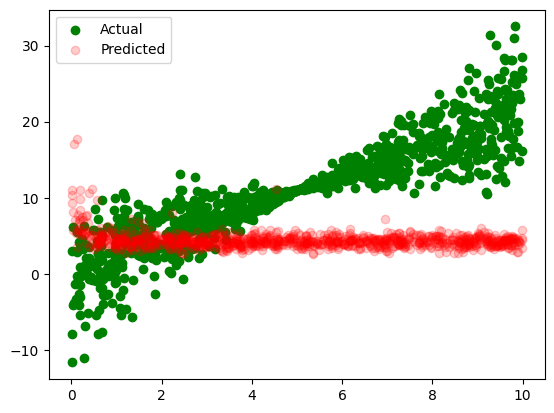

ValueError: Expected parameter scale (Tensor of shape (16897,)) of distribution Normal(loc: torch.Size([16897]), scale: torch.Size([16897])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([0.0017, 0.1008, 0.1008,  ..., 0.5852, 0.6261, 0.5563],
       grad_fn=<LogBackward0>)

In [287]:
epochs = 10
batch_size = 1000
alpha = 0.2
lr = 0.01
bmodel.train()
# optimizer = Adam(bmodel.parameters(), lr=lr)
optimizer = SGD(bmodel.parameters(), lr=lr)
fig, ax = plt.subplots()
scatter_actual = ax.scatter(X_torch, y_torch, color="green", label="Actual")
y_hat, _ = bmodel(X_torch)
scatter_predicted = ax.scatter(
    X_torch,
    y_hat.detach().numpy().squeeze(),
    color="red",
    label="Predicted",
    alpha=alpha,
)
plt.legend()
plt.show()

dataset = TensorDataset(X_torch, y_torch)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for epoch in range(epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        y_hat, w = bmodel(batch_X)
        loss = loss_fn(y_hat, batch_y, w, bmodel.mu, bmodel.rho)
        loss.backward()
        optimizer.step()

    if epoch % 2 == 0:
        # Update the predicted points in the existing plot
        y_hat, _ = bmodel(X_torch)
        scatter_predicted.remove()
        scatter_predicted = ax.scatter(
            X_torch,
            y_hat.detach().numpy().squeeze(),
            color="red",
            label="Predicted",
            alpha=alpha,
        )
        clear_output(wait=True)
        display(fig)
    print(f"epoch={epoch+1}/{epochs} | loss={loss.item()}")


In [293]:
get_variational_pdf(bmodel.mu, bmodel.rho)

ValueError: Expected parameter scale (Tensor of shape (16897,)) of distribution Normal(loc: torch.Size([16897]), scale: torch.Size([16897])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([0.0017, 0.1008, 0.1008,  ..., 0.5852, 0.6261, 0.5563],
       grad_fn=<LogBackward0>)

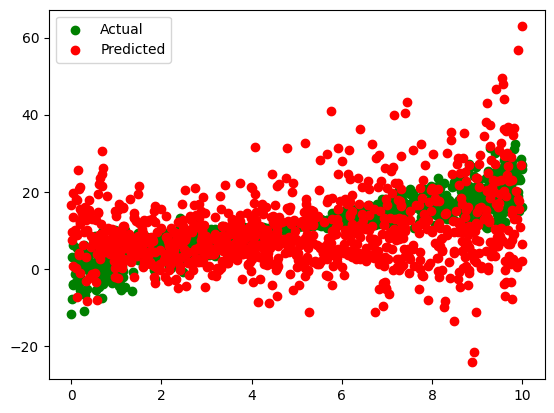

In [278]:
fig, ax = plt.subplots()
epochs = 100
scatter_actual = ax.scatter(X_torch, y_torch, color="green", label="Actual")
y_hat = bmodel(X_torch)[0]
scatter_predicted = ax.scatter(
    X_torch, y_hat.detach().numpy().squeeze(), color="red", label="Predicted"
)
plt.legend()
plt.show()


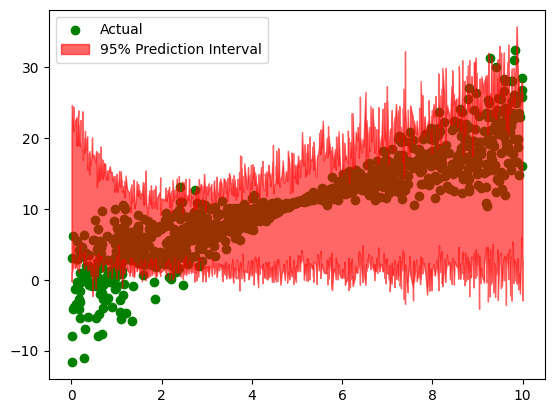

In [279]:
fig, ax = plt.subplots()

# Plot actual data
scatter_actual = ax.scatter(X_torch, y_torch, color="green", label="Actual")

# Number of samples to use for generating prediction intervals
num_samples = 50
predictions = []

sorting = X_torch.squeeze().sort()
X_sorted = sorting.values
y_sorted = y_torch[sorting.indices]

# Run multiple forward passes to get predictions for each input
for _ in range(num_samples):
    y_hat_sample = bmodel(X_sorted)[0]
    predictions.append(y_hat_sample.detach().numpy().squeeze())

# Convert the predictions to a NumPy array for easier manipulation
predictions = np.array(predictions)

# Calculate mean and standard deviation across the samples
y_hat_mean = predictions.mean(axis=0)
y_hat_std = predictions.std(axis=0)

# Calculate the 95% prediction interval (mean ± 1.96 * std)
lower_bound = y_hat_mean -  y_hat_std
upper_bound = y_hat_mean +  y_hat_std

# Sort X_torch and all associated outputs for proper plotting
#X_sorted, y_hat_mean_sorted, lower_bound_sorted, upper_bound_sorted = zip(
#    *sorted(zip(X_torch.squeeze().numpy(), y_hat_mean, lower_bound, upper_bound))
#)

# Plot the prediction interval as a shaded region
ax.fill_between(
    X_sorted,
    lower_bound,
    upper_bound,
    color="red",
    alpha=0.6,
    label="95% Prediction Interval",
)

plt.legend()
plt.show()
